## Lesson 14.4 - Plotting with Seaborn: Plotting with categorical data

*Facsimile of [Seaborn tutorial](http://stanford.edu/~mwaskom/software/seaborn/tutorial.html).*

In the relational plot tutorial we saw how to use different visual representations to show the relationship between multiple variables in a dataset. In the examples, we focused on cases where the main relationship was between two numerical variables. If one of the main variables is “categorical” (divided into discrete groups) it may be helpful to use a more specialized approach to visualization.

In seaborn, there are several different ways to visualize a relationship involving categorical data. Similar to the relationship between `relplot()` and either `scatterplot()` or `lineplot()`, there are two ways to make these plots. There are a number of axes-level functions for plotting categorical data in different ways and a figure-level interface, `catplot()`, that gives unified higher-level access to them.

It’s helpful to think of the different categorical plot kinds as belonging to three different families, which we’ll discuss in detail below. They are:

Categorical scatterplots:

* `stripplot()` (with `kind="strip"`; the default)
* `swarmplot()` (with `kind="swarm"`)

Categorical distribution plots:

* `boxplot()` (with `kind="box"`)
* `violinplot()` (with `kind="violin"`)
* `boxenplot()` (with `kind="boxen"`)

Categorical estimate plots:

* `pointplot()` (with `kind="point"`)
* `barplot()` (with `kind="bar"`)
* `countplot()` (with `kind="count"`)

These families represent the data using different levels of granularity. When knowing which to use, you’ll have to think about the question that you want to answer. The unified API makes it easy to switch between different kinds and see your data from several perspectives.

In this tutorial, we’ll mostly focus on the figure-level interface, `catplot()`. Remember that this function is a higher-level interface each of the functions above, so we’ll reference them when we show each kind of plot, keeping the more verbose kind-specific API documentation at hand.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
import seaborn as sns
#sns.set(style="whitegrid", color_codes=True)

In [4]:
np.random.seed(sum(map(ord, "categorical")))

### Categorical scatterplots

The default representation of the data in `catplot()` uses a scatterplot. There are actually two different categorical scatter plots in seaborn. They take different approaches to resolving the main challenge in representing categorical data with a scatter plot, which is that all of the points belonging to one category would fall on the same position along the axis corresponding to the categorical variable. The approach used by `stripplot()`, which is the default “kind” in `catplot()` is to adjust the positions of points on the categorical axis with a small amount of random “jitter”:

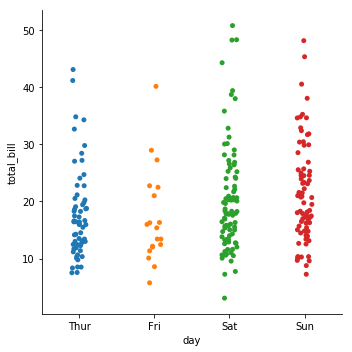

In [5]:
tips = sns.load_dataset("tips")
sns.catplot(x="day", y="total_bill", data=tips);

The `jitter` parameter controls the magnitude of jitter or disables it altogether:

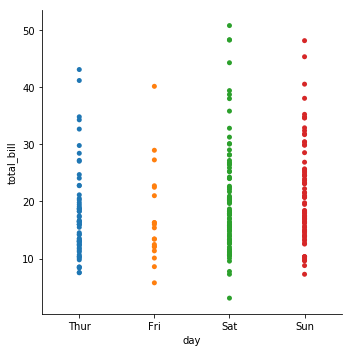

In [6]:
sns.catplot(x="day", y="total_bill", jitter=False, data=tips);

The second approach adjusts the points along the categorical axis using an algorithm that prevents them from overlapping. It can give a better representation of the distribution of observations, although it only works well for relatively small datasets. This kind of plot is sometimes called a “beeswarm” and is drawn in seaborn by `swarmplot()`, which is activated by setting kind="swarm" in `catplot()`:

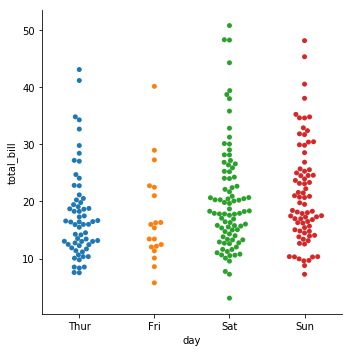

In [7]:
sns.catplot(x="day", y="total_bill", kind="swarm", data=tips);

Similar to the relational plots, it’s possible to add another dimension to a categorical plot by using a `hue` semantic. (The categorical plots do not currently support `size` or `style` semantics). Each different categorical plotting function handles the `hue` semantic differently. For the scatter plots, it is only necessary to change the color of the points:

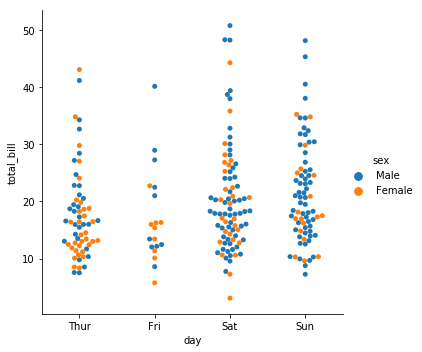

In [8]:
sns.catplot(x="day", y="total_bill", hue="sex", kind="swarm", data=tips);

Unlike with numerical data, it is not always obvious how to order the levels of the categorical variable along its axis. In general, the seaborn categorical plotting functions try to infer the order of categories from the data. If your data have a pandas Categorical datatype, then the default order of the categories can be set there. If the variable passed to the categorical axis looks numerical, the levels will be sorted. But the data are still treated as categorical and drawn at ordinal positions on the categorical axes (specifically, at 0, 1, …) even when numbers are used to label them:

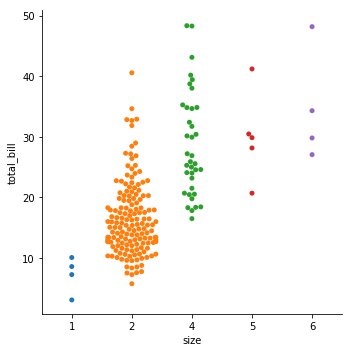

In [9]:
sns.catplot(x="size", y="total_bill", kind="swarm",
            data=tips.query("size != 3"));

The other option for chosing a default ordering is to take the levels of the category as they appear in the dataset. The ordering can also be controlled on a plot-specific basis using the `order` parameter. This can be important when drawing multiple categorical plots in the same figure, which we’ll see more of below:

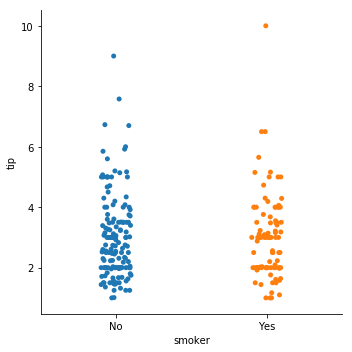

In [10]:
sns.catplot(x="smoker", y="tip", order=["No", "Yes"], data=tips);

We’ve referred to the idea of “categorical axis”. In these examples, that’s always corresponded to the horizontal axis. But it’s often helpful to put the categorical variable on the vertical axis (particularly when the category names are relatively long or there are many categories). To do this, swap the assignment of variables to axes:

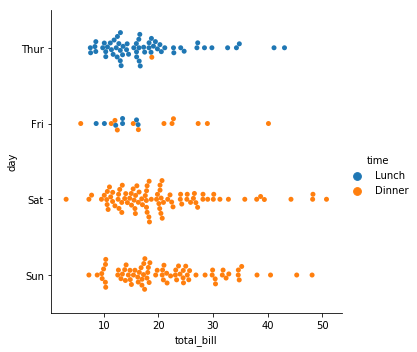

In [11]:
sns.catplot(x="total_bill", y="day", hue="time", kind="swarm", data=tips);

### Distributions of observations within categories

As the size of the dataset grows,, categorical scatter plots become limited in the information they can provide about the distribution of values within each category. When this happens, there are several approaches for summarizing the distributional information in ways that facilitate easy comparisons across the category levels.

#### Boxplots

The first is the familiar `boxplot()`. This kind of plot shows the three quartile values of the distribution along with extreme values. The “whiskers” extend to points that lie within 1.5 IQRs of the lower and upper quartile, and then observations that fall outside this range are displayed independently. This means that each value in the boxplot corresponds to an actual observation in the data.

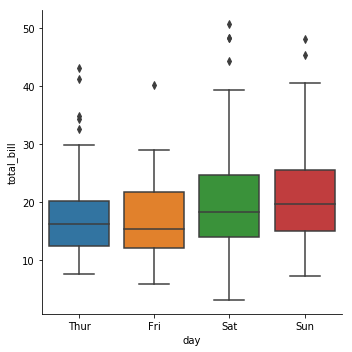

In [12]:
sns.catplot(x="day", y="total_bill", kind="box", data=tips);

When adding a `hue` semantic, the box for each level of the semantic variable is moved along the categorical axis so they don’t overlap:

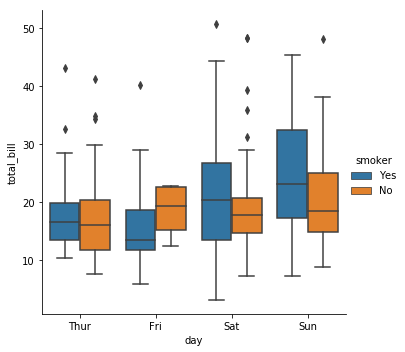

In [13]:
sns.catplot(x="day", y="total_bill", hue="smoker", kind="box", data=tips);

This behavior is called “dodging” and is turned on by default because it is assumed that the semantic variable is nested within the main categorical variable. If that’s not the case, you can disable the dodging:

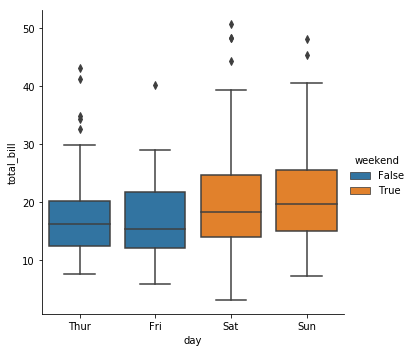

In [14]:
tips["weekend"] = tips["day"].isin(["Sat", "Sun"])
sns.catplot(x="day", y="total_bill", hue="weekend",
            kind="box", dodge=False, data=tips);

A related function, `boxenplot()`, draws a plot that is similar to a box plot but optimized for showing more information about the shape of the distribution. It is best suited for larger datasets:

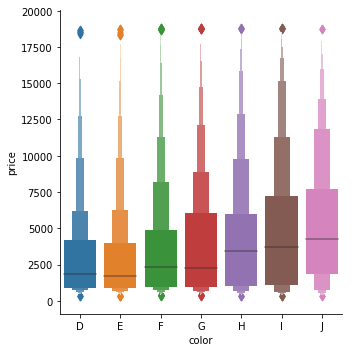

In [15]:
diamonds = sns.load_dataset("diamonds")
sns.catplot(x="color", y="price", kind="boxen",
            data=diamonds.sort_values("color"));

#### Violinplots

A different approach is a `violinplot()`, which combines a boxplot with the kernel density estimation procedure described in the distributions tutorial:

/Users/luke.thompson/miniconda3/envs/python3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


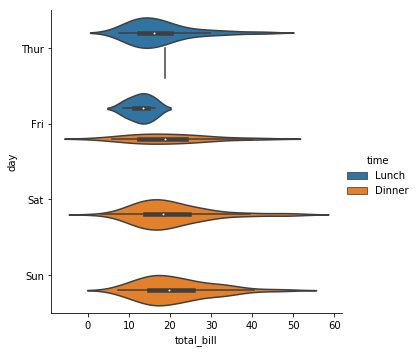

In [16]:
sns.catplot(x="total_bill", y="day", hue="time",
            kind="violin", data=tips);

This approach uses the kernel density estimate to provide a richer description of the distribution of values. Additionally, the quartile and whikser values from the boxplot are shown inside the violin. The downside is that, because the violinplot uses a KDE, there are some other parameters that may need tweaking, adding some complexity relative to the straightforward boxplot:

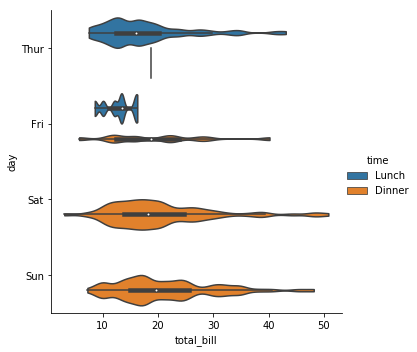

In [17]:
sns.catplot(x="total_bill", y="day", hue="time",
            kind="violin", bw=.15, cut=0,
            data=tips);

It's also possible to "split" the violins when the hue parameter has only two levels, which can allow for a more efficient use of space:

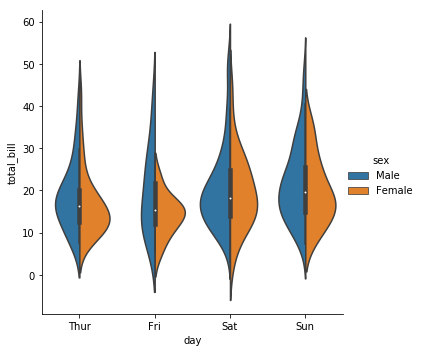

In [18]:
sns.catplot(x="day", y="total_bill", hue="sex",
            kind="violin", split=True, data=tips);

Finally, there are several options for the plot that is drawn on the interior of the violins, including ways to show each individual observation instead of the summary boxplot values:

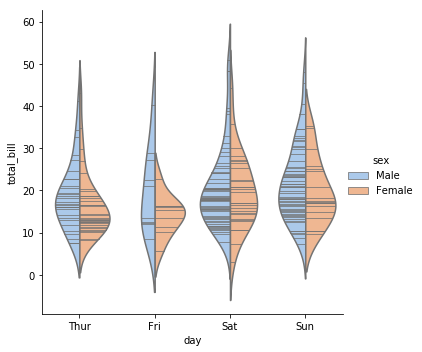

In [19]:
sns.catplot(x="day", y="total_bill", hue="sex",
            kind="violin", inner="stick", split=True,
            palette="pastel", data=tips);

It can also be useful to combine `swarmplot()` or `striplot()` with a box plot or violin plot to show each observation along with a summary of the distribution:

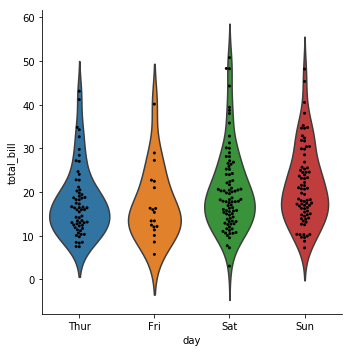

In [20]:
g = sns.catplot(x="day", y="total_bill", kind="violin", inner=None, data=tips)
sns.swarmplot(x="day", y="total_bill", color="k", size=3, data=tips, ax=g.ax);

### Statistical estimation within categories

For other applications, rather than showing the distribution within each category, you might want to show an estimate of the central tendency of the values. Seaborn has two main ways to show this information. Importantly, the basic API for these functions is identical to that for the ones discussed above.

#### Bar plots

A familiar style of plot that accomplishes this goal is a bar plot. In seaborn, the `barplot()` function operates on a full dataset and applies a function to obtain the estimate (taking the mean by default). When there are multiple observations in each category, it also uses bootstrapping to compute a confidence interval around the estimate and plots that using error bars:

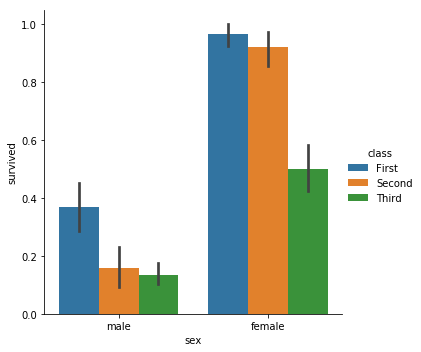

In [21]:
titanic = sns.load_dataset("titanic")
sns.catplot(x="sex", y="survived", hue="class", kind="bar", data=titanic);

A special case for the bar plot is when you want to show the number of observations in each category rather than computing a statistic for a second variable. This is similar to a histogram over a categorical, rather than quantitative, variable. In seaborn, it's easy to do so with the `countplot()` function:

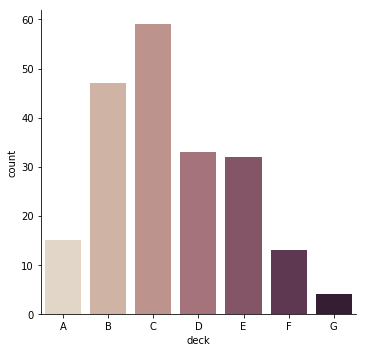

In [22]:
sns.catplot(x="deck", kind="count", palette="ch:.25", data=titanic);

Both `barplot()` and `countplot()` can be invoked with all of the options discussed above, along with others that are demonstrated in the detailed documentation for each function:

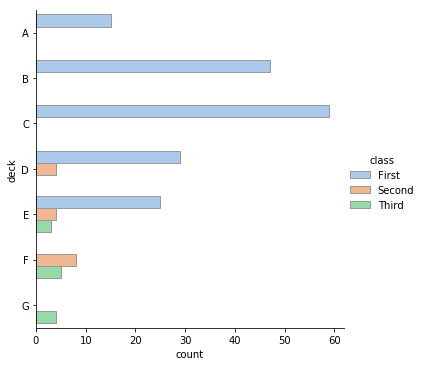

In [23]:
sns.catplot(y="deck", hue="class", kind="count",
            palette="pastel", edgecolor=".6",
            data=titanic);

#### Point plots

An alternative style for visualizing the same information is offered by the `pointplot()` function. This function also encodes the value of the estimate with height on the other axis, but rather than showing a full bar, it plots the point estimate and confidence interval. Additionally, `pointplot()` connects points from the same `hue` category. This makes it easy to see how the main relationship is changing as a function of the hue semantic, because your eyes are quite good at picking up on differences of slopes:

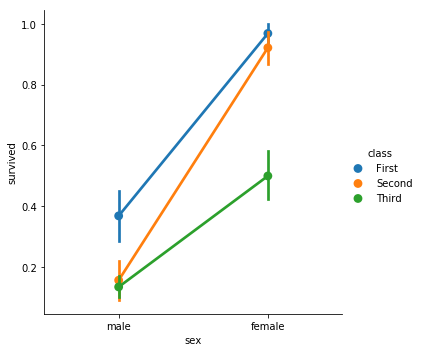

In [24]:
sns.catplot(x="sex", y="survived", hue="class", kind="point", data=titanic);

When the categorical functions lack the `style` semantic of the relational functions, it can still be a good idea to vary the marker and/or linestyle along with the hue to make figures that are maximally accessible and reproduce well in black and white:

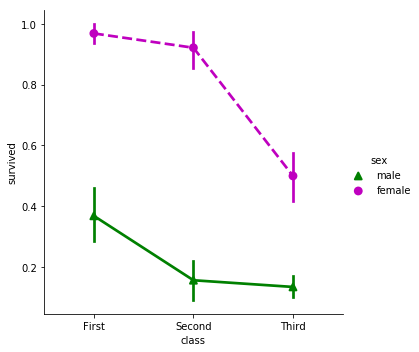

In [25]:
sns.catplot(x="class", y="survived", hue="sex",
            palette={"male": "g", "female": "m"},
            markers=["^", "o"], linestyles=["-", "--"],
            kind="point", data=titanic);

### Plotting “wide-form” data

While using “long-form” or “tidy” data is preferred, these functions can also by applied to “wide-form” data in a variety of formats, including pandas DataFrames or two-dimensional numpy arrays. These objects should be passed directly to the `data` parameter:

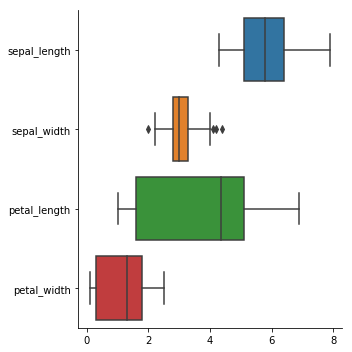

In [26]:
iris = sns.load_dataset("iris")
sns.catplot(data=iris, orient="h", kind="box");

Additionally, the axes-level functions accept vectors of Pandas or numpy objects rather than variables in a `DataFrame`:

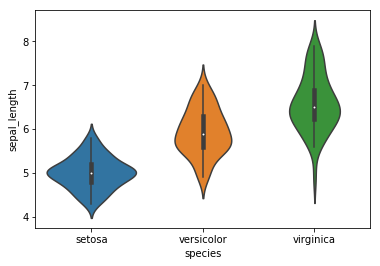

In [27]:
sns.violinplot(x=iris.species, y=iris.sepal_length);

To control the size and shape of plots made by the functions discussed above, you must set up the figure yourself using matplotlib commands:

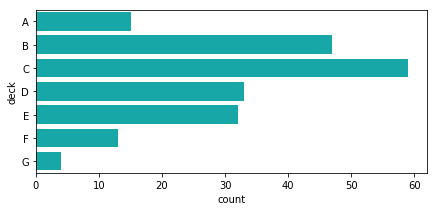

In [28]:
f, ax = plt.subplots(figsize=(7, 3))
sns.countplot(y="deck", data=titanic, color="c");

This is the approach you should take when you need a categorical figure to happily coexist in a more complex figure with other kinds of plots.

### Showing multiple relationships with facets

Just like `relplot()`, the fact that `catplot()` is built on a `FacetGrid` means that it is easy to add faceting variables to visualize higher-dimensional relationships:

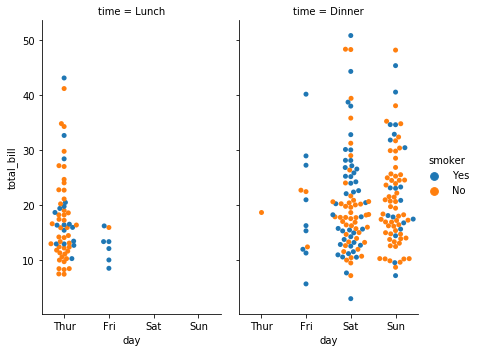

In [29]:
sns.catplot(x="day", y="total_bill", hue="smoker",
            col="time", aspect=.6,
            kind="swarm", data=tips);

For further customization of the plot, you can use the methods on the `FacetGrid` object that it returns:

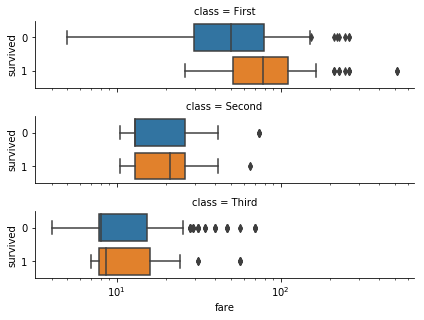

In [30]:
g = sns.catplot(x="fare", y="survived", row="class",
                kind="box", orient="h", height=1.5, aspect=4,
                data=titanic.query("fare > 0"))
g.set(xscale="log");